In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import time
from tqdm import tqdm
from utils.train_preprocessing import my_processing
from utils.CustomDataset_v2 import DataGenerator
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, cohen_kappa_score


import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Conv2D, MaxPool2D, Flatten, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, losses, optimizers, metrics
from tensorflow.keras.callbacks import EarlyStopping

2023-05-12 16:08:21.254936: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 16:08:21.400062: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-12 16:08:21.440509: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-12 16:08:22.061328: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
label_th = 0.1
seg_time = 30
data_folder = f'/NAS/Benson/Sleep_Apnea/Sleep_Codes/Code_with_data/CNN_LSTM/Model_Training/Data'
info_csv = pd.read_csv(f'{data_folder}/label_{seg_time}s_{int(label_th*100)}_binary.csv')
train_data = []
train_label = []
valid_data = []
valid_label = []
train_ids = ["00000782-100816", "00000781-100816", "00001096-100779", "00000712-100839", "00001118-100779"]
valid_ids = ["00000711-100839"]

for x in range(390*len(train_ids)):
    image = cv2.imread(f'{data_folder}/Segments_{seg_time}s/{info_csv["filename"][x]}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    train_data.append(image)
    train_label.append(info_csv["label"][x])

    
for x in range(390*len(train_ids), 390*(len(train_ids)+len(valid_ids))):
    image = cv2.imread(f'{data_folder}/Segments_{seg_time}s/{info_csv["filename"][x]}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    valid_data.append(image)
    valid_label.append(info_csv["label"][x])
    
train_label = tf.keras.utils.to_categorical(train_label, 2)
valid_label = tf.keras.utils.to_categorical(valid_label, 2)

print(len(train_data))
print(len(train_label))
print(len(valid_data))
print(len(valid_label))
del info_csv

1950
1950
390
390


In [3]:
train_data = my_processing(dataset = train_data, outsize=448, pre_type="his")
valid_data = my_processing(dataset = valid_data, outsize=448, pre_type="his")
#train_data, train_label = sklearn.utils.shuffle(train_data, train_label)

100%|████████████████████████████████████████| 390/390 [00:01<00:00, 210.72it/s]


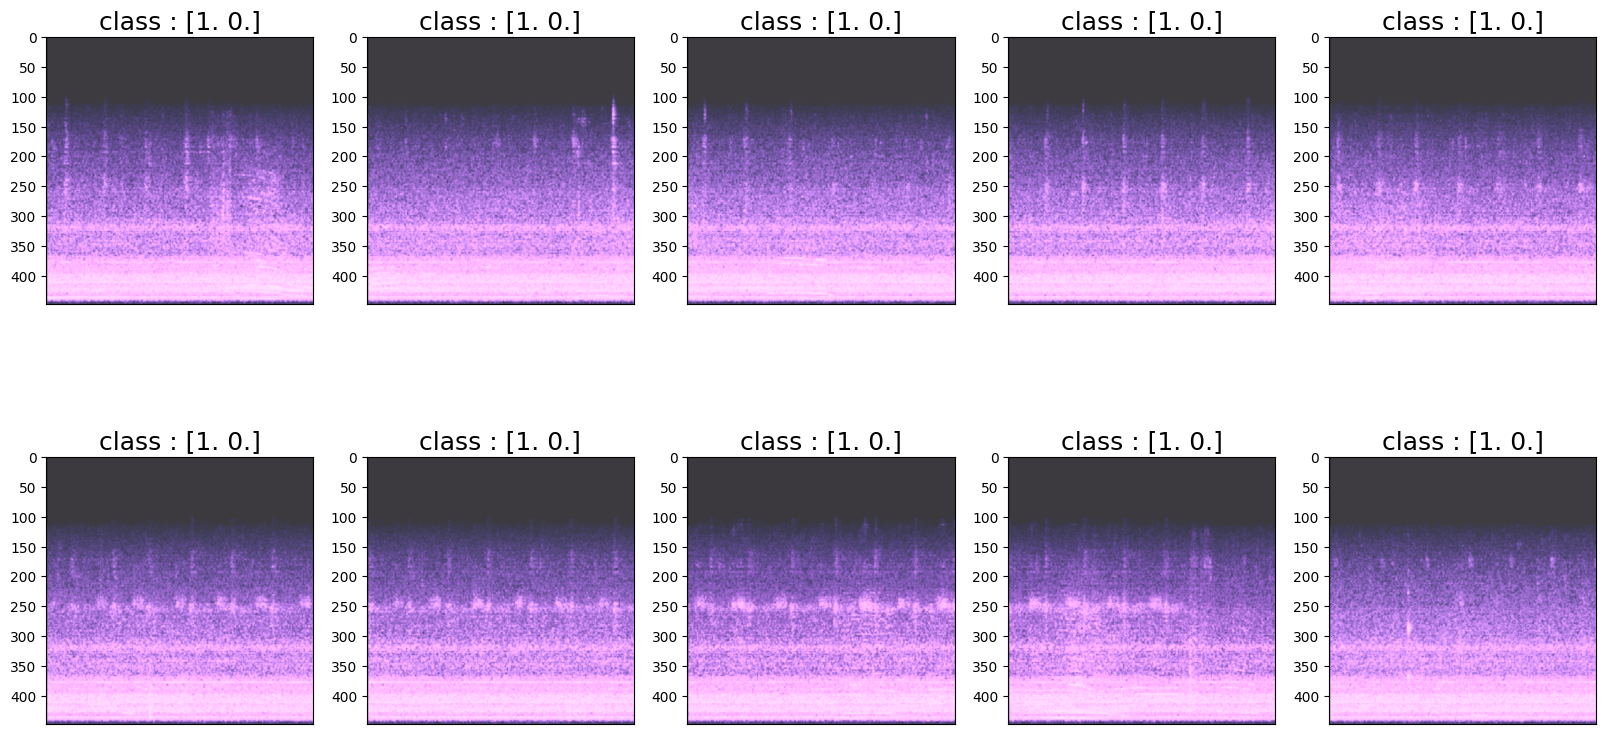

In [4]:
plt.figure(figsize=(20,10))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)                                    
    plt.title("class : " + str(train_label[i]), 
               fontsize=18)                                        
    plt.xticks([])                                                
    ax.imshow(train_data[i])    

In [5]:
def build_model(hp):    

    def my_model(timesteps, img_height, img_width, img_color_channels, num_classes):
        
        input_batch = Input(shape = (timesteps, img_height, img_width, img_color_channels))
        
        
        cnn_network = TimeDistributed(Conv2D(4, (3,3), padding='same', activation='relu'))(input_batch)
        cnn_network = TimeDistributed(Conv2D(4, (3,3), padding='same', activation='relu'))(cnn_network)
        cnn_network = TimeDistributed(BatchNormalization())(cnn_network)
        cnn_network = TimeDistributed(MaxPool2D(pool_size=(2,2), padding='same', strides=(4,4)))(cnn_network)
        
        cnn_network = TimeDistributed(Conv2D(8, (3,3), padding='same', activation='relu'))(cnn_network)
        cnn_network = TimeDistributed(Conv2D(8, (3,3), padding='same', activation='relu'))(cnn_network)
        cnn_network = TimeDistributed(BatchNormalization())(cnn_network)
        cnn_network = TimeDistributed(MaxPool2D(pool_size=(2,2), padding='same', strides=(4,4)))(cnn_network)
        
        cnn_network = TimeDistributed(Conv2D(8, (3,3), padding='same', activation='relu'))(cnn_network)
        cnn_network = TimeDistributed(Conv2D(8, (3,3), padding='same', activation='relu'))(cnn_network)
        cnn_network = TimeDistributed(BatchNormalization())(cnn_network)
        cnn_network = TimeDistributed(MaxPool2D(pool_size=(2,2), padding='same', strides=(4,4)))(cnn_network)
        
        cnn_network = TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'))(cnn_network)
        cnn_network = TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'))(cnn_network)
        cnn_network = TimeDistributed(BatchNormalization())(cnn_network)
        cnn_network = TimeDistributed(MaxPool2D(pool_size=(2,2), padding='same', strides=(4,4)))(cnn_network)
        
        cnn_network = TimeDistributed(Flatten())(cnn_network)
    
        hp_lstm_units = hp.Choice('lstm_units', values=[7, 8, 9, 10, 11, 12])
        hp_dropout = hp.Float('dropout', min_value=0.05, max_value=0.4, step=0.05)

        lstm_network = LSTM(hp_lstm_units, return_sequences=False, dropout=hp_dropout, recurrent_dropout=hp_dropout)(cnn_network)

        lstm_network = Dense(8,activation='relu')(lstm_network)
        lstm_network = Dropout(hp_dropout)(lstm_network)
        lstm_network = Dense(4,activation='relu')(lstm_network)
        lstm_network = Dropout(hp_dropout)(lstm_network)
        lstm_network = Dense(num_classes, activation='softmax')(lstm_network)
        
        
        full_network = Model(input_batch, lstm_network)


        return full_network
    
    model = my_model(timesteps = 10,
                 img_height = 448,
                 img_width = 448,
                 img_color_channels = 3,
                 num_classes = 2)
    
    hp_lr = hp.Choice('lr', values=[1e-6, 5*1e-6, 1e-5, 5*1e-5, 1e-4, 5*1e-4])
    
    model.compile(optimizer=Adam(learning_rate=hp_lr),
              loss='categorical_crossentropy', 
              metrics=['accuracy'],
              )
    
    return model

In [6]:
train_dataset = DataGenerator(data = train_data, 
                              label = train_label, 
                              batch_size = 10, 
                              patient_num = len(train_ids), 
                              seg_time = seg_time, 
                              timesteps = 10,
                              return_label = True)

valid_dataset = DataGenerator(data = valid_data, 
                              label = valid_label, 
                              batch_size = 10, 
                              patient_num = len(valid_ids), 
                              seg_time = seg_time, 
                              timesteps = 10,
                              return_label = True)

In [7]:
num_epochs = 500
tuner = kt.RandomSearch(
    hypermodel = build_model,
    objective = 'val_accuracy',
    max_trials = 10,
    execution_per_trial = 3,
    directory = 'Tuner_Test'
    project_name = 'Project 1'
)

tuner.search(x = train_dataset,
             validation_data = valid_dataset,
             callbacks = [EarlyStopping(monitor = 'val_loss',
                                        patience = 20,
                                        verbose = 1)],
             epochs = num_epochs
                   )
print(f'Total time: {time.perf_counter() - start_time} sec')

Trial 10 Complete [00h 06m 42s]
val_accuracy: 0.19947506487369537

Best val_accuracy So Far: 0.8031495809555054
Total elapsed time: 00h 54m 47s
INFO:tensorflow:Oracle triggered exit
Total time: 3286.810458767228 sec


In [8]:
##training v2

# loss_fn = losses.CategoricalCrossentropy()
# optimizer = optimizers.Adam(learning_rate=1e-5)
# acc_metric = metrics.CategoricalAccuracy()


# def train(timesteps):
#     train_acc_his = []
#     train_loss_his = []
#     val_acc_his = []
#     val_loss_his = []

#     num_epoch = 200
#     batch_size = 10
#     seg_per_person = 11700//seg_time
#     win_per_person = seg_per_person-timesteps+1
#     train_size = (win_per_person)*4
#     start_time = time.perf_counter()
#     for epoch in range(num_epoch):
        
#         id_generator = timestep_id_generator(len(ids), seg_per_person, timesteps)
#         step_size = train_size//batch_size
#         print(f'Training Epoch {epoch+1}')

        
#         for batch in range(step_size + 1):
                 
                
#             if batch == step_size:

#                 if train_size % batch_size == 0:
#                     continue

#                 else:
#                     print([[(n := next(id_generator)), (n+timesteps)]for _ in range(train_size-batch*batch_size)])
#                     print([(n-train_size+batch*batch_size+timesteps), (n+timesteps)])
#                     x_batch = np.array([train_data[(n := next(id_generator)) : (n+timesteps)] for _ in range(train_size-batch*batch_size)])
#                     y_batch = train_label[(n-train_size+batch*batch_size+timesteps) : (n+timesteps)]
                    
            
#             elif 1 <= win_per_person*((batch*batch_size)//win_per_person+1) - batch*batch_size <= batch_size-1:
#                 print([[(n := next(id_generator)), (n+timesteps)] for _ in range(batch_size)])
#                 print([[n-batch_size+1, seg_per_person*((batch*batch_size)//win_per_person+1)], 
#                        [seg_per_person*((batch*batch_size)//win_per_person+1)+timesteps-1, n+timesteps]])
#                 x_batch = np.array([train_data[(n := next(id_generator)) : (n+timesteps)] for _ in range(batch_size)])
#                 y_batch = np.concatenate((train_label[n-batch_size+1 : seg_per_person*((batch*batch_size)//win_per_person+1)],
#                                          train_label[seg_per_person*((batch*batch_size)//win_per_person+1)+timesteps-1 : n+timesteps]),
#                                          axis = 0)
                
            
#             else:
#                 print([[(n := next(id_generator)), (n+timesteps)] for _ in range(batch_size)])
#                 print([(n-batch_size+timesteps), (n+timesteps)])
#                 x_batch = np.array([train_data[(n := next(id_generator)) : (n+timesteps)] for _ in range(batch_size)])
#                 y_batch = train_label[(n-batch_size+timesteps):(n+timesteps)]

        
#             with tf.GradientTape() as tape:
#                 y_pred = model(x_batch, training = True)
#                 loss = loss_fn(y_batch, y_pred)
#             gradients = tape.gradient(loss, model.trainable_variables)
#             optimizer.apply_gradients(zip(gradients, model.trainable_variables))
#             acc_metric.update_state(y_batch, y_pred)

#         print(f'accuracy: {acc_metric.result()}, loss: {loss}')
#         train_acc_his.append(tf.get_static_value(acc_metric.result()))
#         train_loss_his.append(tf.get_static_value(loss))
#         acc_metric.reset_state()

#         y_val_pred = model(x_test, training=False)
#         val_loss = loss_fn(y_test, y_val_pred)
#         acc_metric.update_state(y_test, y_val_pred)

#         print(f'val_accuracy: {acc_metric.result()}, val_loss: {val_loss}')
#         print()
#         val_acc_his.append(tf.get_static_value(acc_metric.result()))
#         val_loss_his.append(tf.get_static_value(val_loss))
#         acc_metric.reset_state()

#     print(f'Total time: {time.perf_counter()-start_time} sec')
#     return train_acc_his, train_loss_his, val_acc_his, val_loss_his

# results = train(timesteps = timestep)

In [9]:
# def num():
#     for i in range(10):
#         yield i
# test = num()
# num_list = []
# for test_num in num():
#     num_list.append(test_num)
# print(num_list[0:6])
# new_list = [num_list[(n := next(test)):n+2] for _ in range(4)]
# print(new_list)

In [10]:
# plt.plot(results[1], label="training_loss")
# plt.plot(results[3], label="validation_loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Learning Curve")
# plt.legend(loc='best')
# plt.show()

In [11]:
# plt.plot(results[0])
# plt.plot(results[2])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

In [12]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

start_time = time.perf_counter()

model_history = model.fit(x = train_dataset,
                    validation_data = valid_dataset,
                    callbacks = [EarlyStopping(monitor = 'val_loss',
                                        patience = 20,
                                        verbose = 1)],
                    epochs = num_epochs)

print(f'Total time: {time.perf_counter() - start_time} sec')


val_acc_per_epoch = model_history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/200
191/191 [==============================] - 60s 293ms/step - loss: 0.7163 - accuracy: 0.4378 - val_loss: 0.6647 - val_accuracy: 0.8031
Epoch 2/200
191/191 [==============================] - 57s 298ms/step - loss: 0.7155 - accuracy: 0.4415 - val_loss: 0.6454 - val_accuracy: 0.8031
Epoch 3/200
191/191 [==============================] - 57s 297ms/step - loss: 0.7133 - accuracy: 0.4394 - val_loss: 0.6827 - val_accuracy: 0.6273
Epoch 4/200
191/191 [==============================] - 57s 296ms/step - loss: 0.7076 - accuracy: 0.4598 - val_loss: 0.6812 - val_accuracy: 0.5617
Epoch 5/200
191/191 [==============================] - 55s 289ms/step - loss: 0.7043 - accuracy: 0.4646 - val_loss: 0.6868 - val_accuracy: 0.5564
Epoch 6/200
191/191 [==============================] - 55s 287ms/step - loss: 0.6998 - accuracy: 0.4892 - val_loss: 0.6952 - val_accuracy: 0.5013
Epoch 7/200
191/191 [==============================] - 55s 284ms/step - loss: 0.6980 - accuracy: 0.4898 - val_loss: 0.7008 -

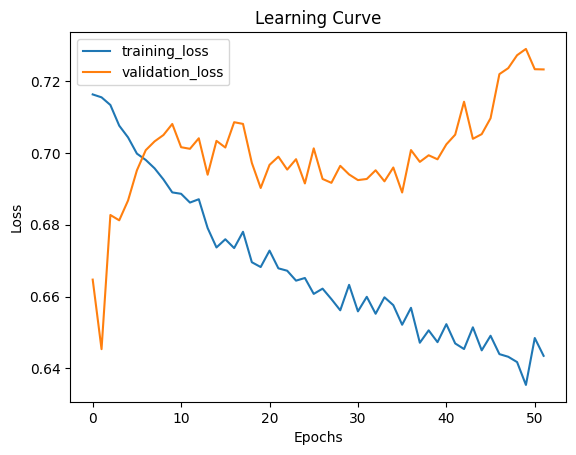

In [13]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

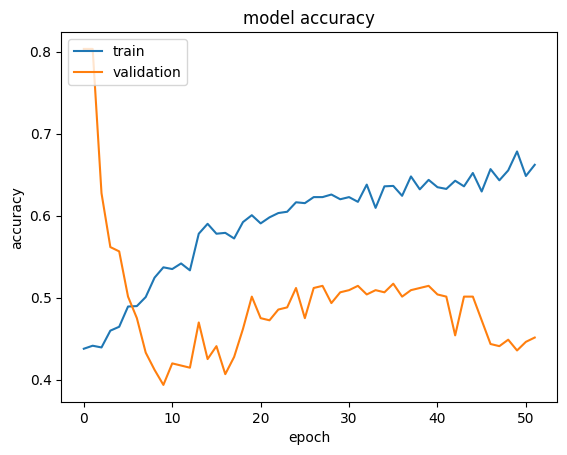

In [14]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [15]:
# test_pred = model(np.array([train_data[n:(n+10)] for n in range(30)]))
# print(test_pred)
# print(train_label[9:40])

In [16]:
test_dataset = DataGenerator(data = valid_data, 
                             label = valid_label, 
                             batch_size = 10, 
                             patient_num = len(valid_ids), 
                             seg_time = seg_time, 
                             timesteps = 10,
                             return_label = False)

pred = model.predict(test_dataset)
print("predictions: ")
print(pred[0:5])
print("answer : ")
print(valid_label[0:5])

39/39 [==============================] - 10s 245ms/step
predictions: 
[[0.59498334 0.4050167 ]
 [0.5894707  0.41052926]
 [0.5717373  0.4282627 ]
 [0.5847093  0.41529065]
 [0.59503615 0.40496388]]
answer : 
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


(390, 2)
(381, 2)
ROC_AUC_Score: 0.4326797385620915



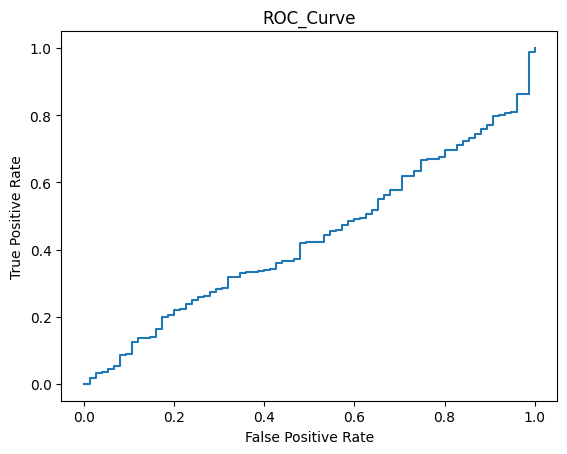

In [17]:
print(valid_label.shape)
print(pred.shape)
print(f'ROC_AUC_Score: {roc_auc_score(valid_label[9:], pred)}')
print()
fpr, tpr, _ = roc_curve(valid_label[9:][:,1], pred[:,1])
plt.plot(fpr, tpr)
plt.title('ROC_Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [18]:
print('Confusion Matrix: ')
print(confusion_matrix(valid_label[9:].argmax(-1), pred.argmax(-1)))
print()
print(f'Cohen_Kappa_Score: {cohen_kappa_score(valid_label[9:].argmax(-1), pred.argmax(-1))}')

Confusion Matrix: 
[[ 33  42]
 [167 139]]

Cohen_Kappa_Score: -0.06491474423269805


In [19]:
# model.save("lstm.h5(1)")